In [3]:
import nbimporter

In [5]:
from dataset import load_datasets 
from model import get_model  
import torch
import torch.optim as optim
import torch
import torch.nn as nn

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader, val_loader, test_loader = load_datasets("pedestrian_risk_analysis.csv")

Using cache found in /home/nhansen3/.cache/torch/hub/pytorch_vision_v0.10.0


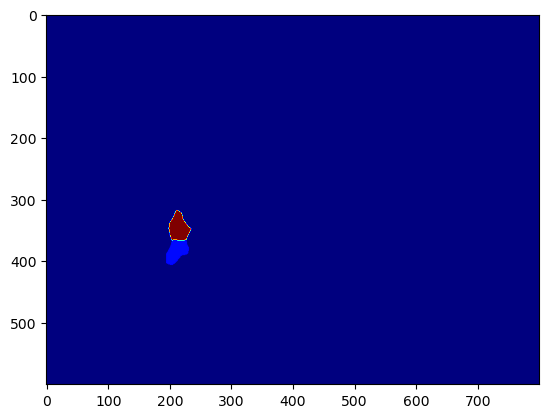

In [11]:
import torch
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt

model = torch.hub.load("pytorch/vision:v0.10.0", "deeplabv3_resnet101", pretrained=True)
model.eval()

image = Image.open("/projects/dsci410_510/DAVID-sim/m1596437/Images/Video_002/v002_0002.png")
transform = T.Compose([T.ToTensor()])
image_tensor = transform(image).unsqueeze(0)

with torch.no_grad():
    output = model(image_tensor)["out"][0]

output_predictions = output.argmax(0)

plt.imshow(output_predictions, cmap="jet")
plt.show()


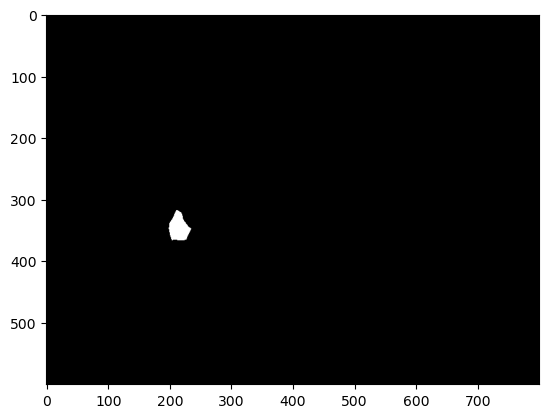

In [12]:
import numpy as np

pedestrian_class_index = 15

pedestrian_mask = (output_predictions == pedestrian_class_index).numpy()

plt.imshow(pedestrian_mask, cmap="gray")
plt.show()

In [13]:
def get_bounding_box(mask):
    rows = np.any(mask, axis=1)
    cols = np.any(mask, axis=0)
    if rows.any() and cols.any():
        rmin, rmax = np.where(rows)[0][[0, -1]]
        cmin, cmax = np.where(cols)[0][[0, -1]]
        return rmin, rmax, cmin, cmax
    return None  

bbox = get_bounding_box(pedestrian_mask)

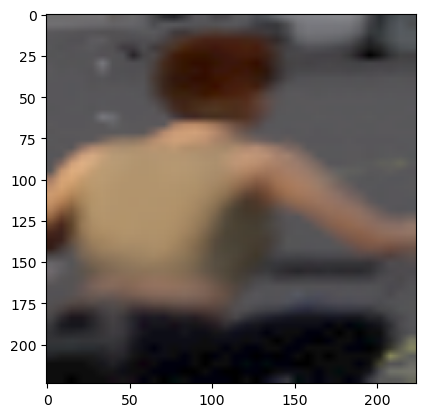

In [22]:
from torchvision.transforms.functional import crop

if bbox:
    rmin, rmax, cmin, cmax = bbox
    cropped_pedestrian = image.crop((cmin, rmin, cmax, rmax)) 

    transform_resize = T.Resize((224, 224))
    resized_pedestrian = transform_resize(cropped_pedestrian)

    plt.imshow(resized_pedestrian)
    plt.show()
else:
    print("No pedestrian detected.")

In [25]:
classifier = get_model(device)

transform = T.Compose([
    T.Resize((128, 128)), 
    T.Grayscale(num_output_channels=3),  # Convert to 3 channels
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

input_tensor = transform(resized_pedestrian).unsqueeze(0).to(device)

with torch.no_grad():
    classification_output = classifier(input_tensor)
    predicted_class = classification_output.argmax(dim=1).item()

print(f"Predicted Class: {predicted_class}")

Predicted Class: 0


In [30]:
output_pil = Image.fromarray(output_predictions.byte().cpu().numpy())

transform = T.Compose([
    T.Resize((128, 128)),  
    T.Grayscale(num_output_channels=3),  
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

processed_input = transform(output_pil).unsqueeze(0)  

In [31]:
classifier = get_model(device)
classifier.eval()

with torch.no_grad():
    prediction = classifier(processed_input.to(device))
    predicted_class = prediction.argmax(dim=1).item()

print(f"Predicted Class: {predicted_class}")

Predicted Class: 1
